# 전복 나이 예측 경진대회

`-` 참고: https://dacon.io/competitions/official/235877/codeshare/4695?page=1&dtype=recent

## 패키지 import 및 데이터 전처리

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter('ignore')

In [7]:
df = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/전복-나이-예측/Data/train.csv')

In [8]:
df.head()

,id,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
0,1,M,0.605,0.470,0.115,1.1140,0.3925,0.2910,0.3100,15
1,2,I,0.430,0.315,0.095,0.3780,0.1750,0.0800,0.1045,8
2,3,I,0.580,0.490,0.195,1.3165,0.5305,0.2540,0.4100,18
3,4,M,0.535,0.405,0.175,1.2705,0.5480,0.3265,0.3370,13
4,5,I,0.310,0.235,0.090,0.1270,0.0480,0.0310,0.0400,6


In [15]:
df.isnull().sum() ## 결측치 확인

Gender            0
Lenght            0
Diameter          0
Height            0
Whole Weight      0
Shucked Weight    0
Viscra Weight     0
Shell Weight      0
Target            0
dtype: int64

In [11]:
df.drop('id', axis=1, inplace=True) ## id 컬럼 드랍

## EDA

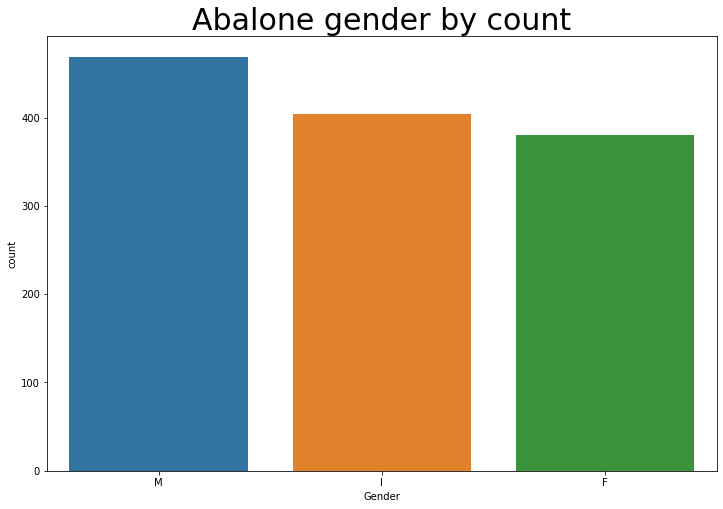

In [37]:
plt.figure(figsize=(12, 8))
sns.countplot('Gender', data=df)
plt.title('Abalone gender by count', fontsize=30)
plt.show()

`-` 전복은 성별이 3개이다(I는 Infant(영유야?))

In [14]:
np.sort(df['Target'].unique())

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 29], dtype=int64)

`-` 나이가 3세 ~ 23세 그리고 29세가 데이터에 존재

In [27]:
df.groupby('Target').size()

Target
3       5
4      14
5      37
6      88
7     107
8     174
9     200
10    202
11    141
12     79
13     62
14     42
15     26
16     21
17     13
18     12
19      8
20     11
21      5
22      2
23      3
29      1
dtype: int64

`-` 전복 나이의 범주가 많지 않고 값이 연속적으로 나타나므로 빈도 막대를 그리자

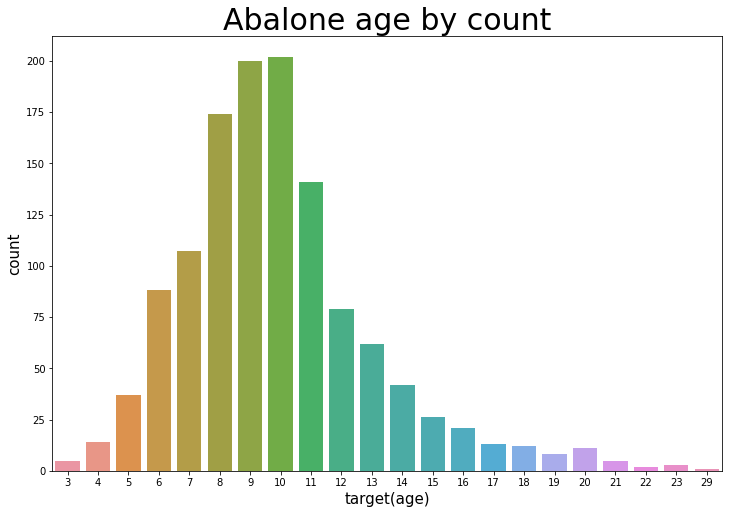

In [34]:
## 전복의 나이 분포 시각화
plt.figure(figsize=(12, 8))
sns.countplot('Target' , data=df)
plt.title('Abalone age by count', fontsize=30)
plt.xlabel('target(age)', fontsize=15)
plt.ylabel('count', fontsize=15)
plt.show()

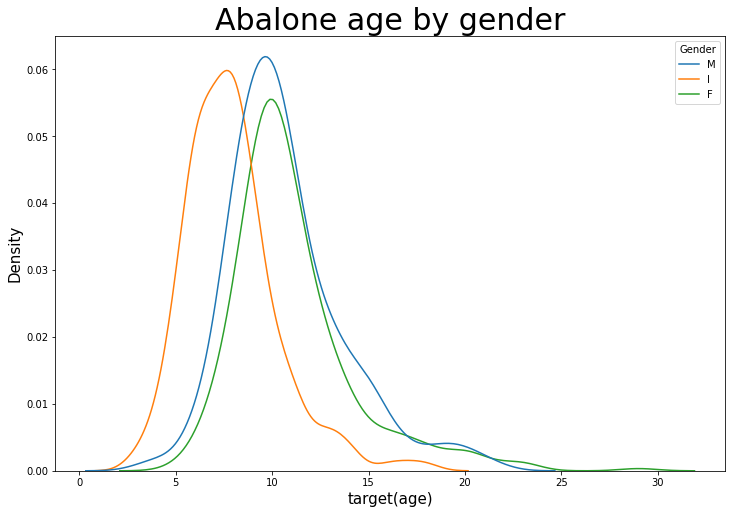

In [40]:
## Gender별 나이의 분포 시각화
plt.figure(figsize=(12, 8))
sns.kdeplot('Target', hue='Gender', data=df)
plt.title('Abalone age by gender', fontsize=30)
plt.xlabel('target(age)', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.show()

`-` 성별이 I인 경우 나이가 더 어리다

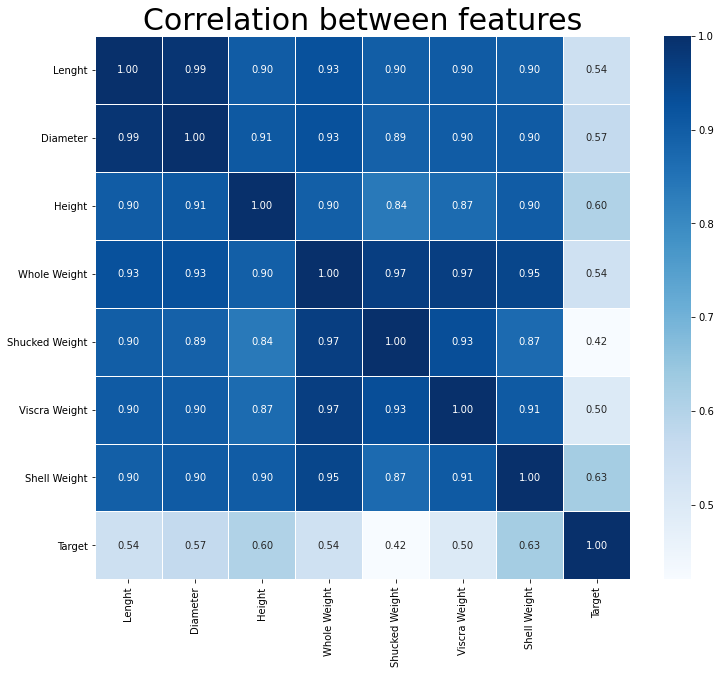

In [46]:
## 수치형 데이터 상관관계 히트맵 시각화
df_ = df.drop('Gender', axis=1)
df_corr = df_.corr(method= 'pearson')
plt.figure(figsize=(12, 10))
sns.heatmap(data=df_corr, annot=True, fmt='.2f', linewidths=.5, cmap='Blues')
plt.title('Correlation between features', fontsize=30)
plt.show()

`-` 설명변수간의 상관계수가 크다

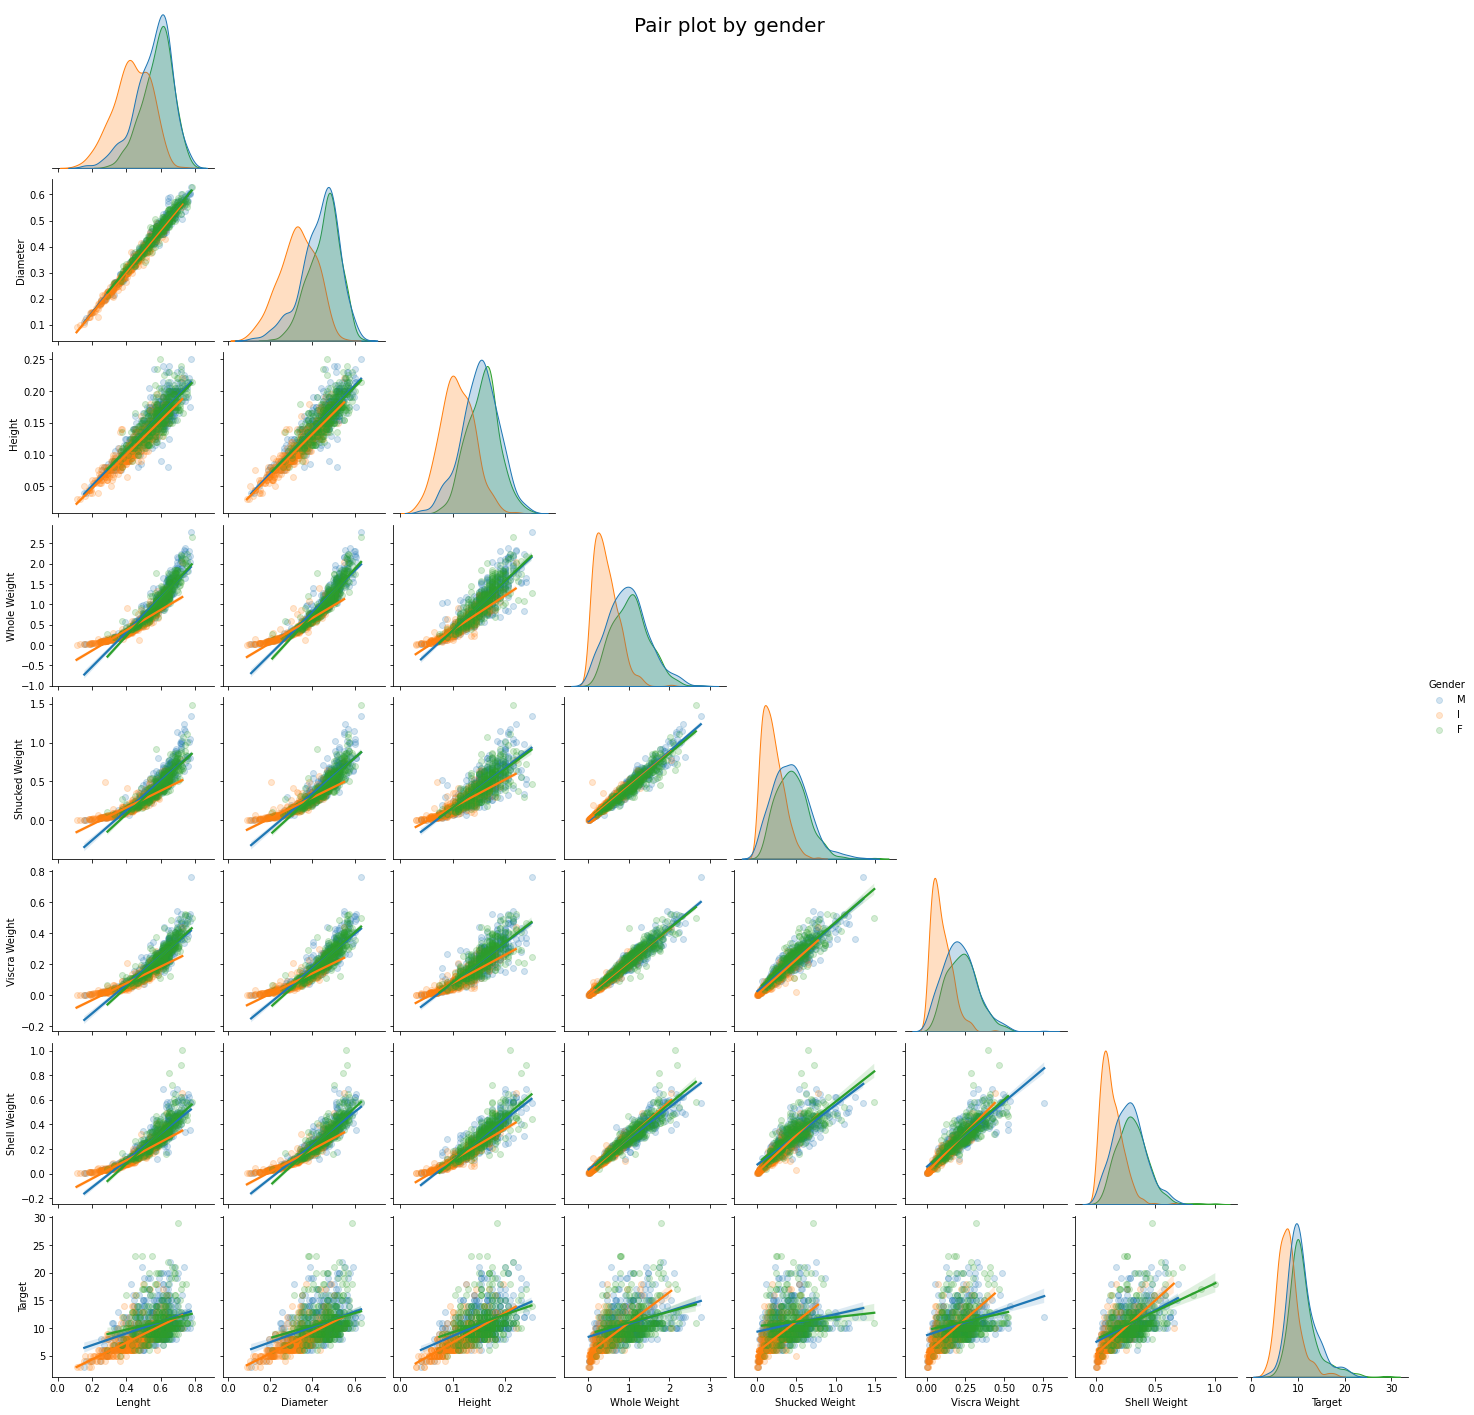

In [57]:
sns.pairplot(df, hue='Gender', kind='reg', corner=True, plot_kws={'scatter_kws': {'alpha': 0.2}})
plt.suptitle('Pair plot by gender', fontsize=20)
plt.show()